## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook. 

In [4]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
#Model
from sklearn.ensemble import RandomForestRegressor



sns.set()

In [13]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [14]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [15]:
def createLagFeature(name_features,lag,df):
    for name_feature in name_features:
        for i in range(1,lag+1):
            df[name_feature+"lag"+str(i)]=df[name_feature].shift(i)
    return df

---

## Cargar y preparar los datos.

In [5]:
df = pd.read_csv("../../Datasets/Datos_durante_pandemia/data_durante_vol_in_ic.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Vol. Futuros': 'VolFuturos'})
df

Fecha  VolFuturos        VIX  EMV-ID     EPU    PI    MHI   FNI    SI
0   2020-01-01    1.289946  12.548403    1.89  186.06  0.00   0.00  0.00  0.00
1   2020-01-02    0.735046  12.470000    2.84  139.13  0.00   0.00  0.00  0.00
2   2020-01-03    0.591834  14.020000    1.33  108.10  0.00   0.00  0.00  0.00
3   2020-01-04    1.367154  14.646666    0.00  212.82  0.00   0.00  0.00  0.00
4   2020-01-05    1.505321  14.311970    0.86  173.76  0.00   0.00  0.00  0.00
..         ...         ...        ...     ...     ...   ...    ...   ...   ...
913 2022-07-02    0.778572  25.922916   11.11  130.95  4.66  25.71  0.19 -3.56
914 2022-07-03    0.819483  26.641413   23.06  135.95  0.42   7.76  0.00 -3.67
915 2022-07-04    0.843804  27.530000   15.98  309.83  0.54  31.37  0.27 -5.85
916 2022-07-05    0.850985  27.540000   18.90  116.59  0.48  38.21  0.12 -4.97
917 2022-07-06    0.840437  26.730000    2.27   91.52  0.52  27.93  0.00 -7.87

[918 rows x 9 columns]

---

## Desarrollo del modelo

In [17]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [18]:
df_stats=df

In [19]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["VolFuturos"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
#df_label=sc.fit_transform(df_label)
#df_data_normalize=sc2.fit_transform(df_data)


In [21]:
def Model(df_data,df_label,lag,estimators):
    
    df_data_lags=createLagFeature(df_data.columns,lag,df_data) if lag>0 else df_data
    df_data_lags.drop(columns="VolFuturos",inplace=True)
    df_data_lags=df_data_lags[lag:]
    #transform data
    df_data_lags=sc2.fit_transform(df_data_lags)
    
    #split data
    #last index of the train data
    seventy_percent=int(len_data*0.7)

    #split the data normalize
    
    df_train=df_data_lags[:seventy_percent]
    df_test=df_data_lags[seventy_percent:]

    #split labels
    df_label=df_label[lag:]
    df_train_y=df_label[:seventy_percent]
    df_test_y=df_label[seventy_percent:]
    #split labels normalize
    
    df_label_normalize=sc.fit_transform(df_label)
    df_train_y_normalize=df_label_normalize[:seventy_percent]
    df_test_y_normalize=df_label_normalize[seventy_percent:]
    print(df_test_y_normalize.shape)
    print(df_test.shape)


    #make model
    model=RandomForestRegressor(n_estimators=estimators)
    #fit the model with the train data
    history=model.fit(df_train,df_train_y_normalize)
   
    # make predictions
    trainPredict = model.predict(df_train)
    trainPredict = np.reshape(trainPredict,(len(trainPredict),1))
    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    testPredict = model.predict(df_test)
    # invert transformation
    testPredict = np.reshape(testPredict,(len(testPredict),1))
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    print("len test: ",testY.shape)
    print("len PREDICT: ",testPredict.shape)
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:][:seventy_percent],"typeRandomForest":["train"]*len(trainPredict.flatten()),"RandomForest" :trainPredict.flatten()}
            ,{"Fecha":df_stats.Fecha[lag:][seventy_percent:],"typeRandomForest":["test"]*len(testPredict.flatten()),"RandomForest":testPredict.flatten()}]

    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()+1, testPredict.flatten()+1,False)}

## Resultados

(273, 1)
(273, 31)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.23242446703138891
MAE is : 0.3417463196958546
RMSE is : 0.4821042076474638
MAPE is : 16.52150146455557
Evaluation metric results:
MSE is : 1.3344025660627148
MAE is : 0.906462653348102
RMSE is : 1.1551634369485189
MAPE is : 46.5863638753855
(273, 1)
(273, 31)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.2200186855589273
MAE is : 0.34013179237602276
RMSE is : 0.4690614944321558
MAPE is : 16.65674938619571
Evaluation metric results:
MSE is : 1.313634172653481
MAE is : 0.890827304845394
RMSE is : 1.1461388103774695
MAPE is : 45.74413291051825
(273, 1)
(273, 31)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.21880635221841846
MAE is : 0.33458387208442286
RMSE is : 0.46776741252295295
MAPE is : 16.447767651977877
Evaluation metric results:
MSE is : 1.2836270465599269
MAE is : 0.8829044863300564
RMSE is : 1.1329726592287772
MAPE is : 45.49410612882087
(273, 1)
(273, 31)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.21612829380021653
MAE is : 0.334494039892686
RMSE is : 0.4648960032095528
MAPE is : 16.316497265728252
Evaluation metric results:
MSE is : 1.3166718112543876
MAE is : 0.8925139735160342
RMSE is : 1.147463206928391
MAPE is : 45.63237905799396
(273, 1)
(273, 31)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.21840575148069902
MAE is : 0.33491997868551066
RMSE is : 0.46733901129768635
MAPE is : 16.430232663829187
Evaluation metric results:
MSE is : 1.32186783367624
MAE is : 0.8944600623131613
RMSE is : 1.1497251122230217
MAPE is : 45.83653641033241
(271, 1)
(271, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.2526806013163105
MAE is : 0.3457029533704045
RMSE is : 0.502673453960233
MAPE is : 16.727045144959636
Evaluation metric results:
MSE is : 1.3975633690160725
MAE is : 0.9066550535667919
RMSE is : 1.1821858436879003
MAPE is : 46.216702953429326
(271, 1)
(271, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.2284635844045312
MAE is : 0.3354931385098752
RMSE is : 0.4779786442975577
MAPE is : 16.35982096157385
Evaluation metric results:
MSE is : 1.3592397573613224
MAE is : 0.9019881542199273
RMSE is : 1.16586438206222
MAPE is : 46.023392910192086
(271, 1)
(271, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.2191001123148653
MAE is : 0.33744678531709454
RMSE is : 0.4680813095124236
MAPE is : 16.534369341058095
Evaluation metric results:
MSE is : 1.3207412440189594
MAE is : 0.8799423024828618
RMSE is : 1.1492350690868076
MAPE is : 44.966748544224835
(271, 1)
(271, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.21596773497601612
MAE is : 0.3348261526713455
RMSE is : 0.46472328860948653
MAPE is : 16.418975119195064
Evaluation metric results:
MSE is : 1.3097688176537707
MAE is : 0.8772076862601894
RMSE is : 1.1444513172930384
MAPE is : 44.44131066792731
(271, 1)
(271, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.21299262075717088
MAE is : 0.3348403514990488
RMSE is : 0.4615112357864875
MAPE is : 16.405065827588906
Evaluation metric results:
MSE is : 1.3346616925296664
MAE is : 0.8841000320081286
RMSE is : 1.155275591592615
MAPE is : 45.142891609765684
(269, 1)
(269, 63)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.25211008560245973
MAE is : 0.34852700117500107
RMSE is : 0.5021056518328186
MAPE is : 16.83573647686899
Evaluation metric results:
MSE is : 1.342996894379507
MAE is : 0.8837403985308571
RMSE is : 1.1588774285400105
MAPE is : 44.730990835441084


<ipython-input-4-f7487097fa4e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=[15,8])


(269, 1)
(269, 63)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.22487727699674073
MAE is : 0.3449521253423972
RMSE is : 0.47421226997700167
MAPE is : 17.087063607895967
Evaluation metric results:
MSE is : 1.3787252536667796
MAE is : 0.9120457692250793
RMSE is : 1.174191319022066
MAPE is : 46.61463628976395
(269, 1)
(269, 63)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.22317659821746302
MAE is : 0.3382530670378322
RMSE is : 0.4724157048802072
MAPE is : 16.671670382272506
Evaluation metric results:
MSE is : 1.3302090746023891
MAE is : 0.8938086480082035
RMSE is : 1.1533469012410746
MAPE is : 45.79651702649458
(269, 1)
(269, 63)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.2202589438625298
MAE is : 0.33877111221747436
RMSE is : 0.46931752989051007
MAPE is : 16.6568928270999
Evaluation metric results:
MSE is : 1.3019172161296995
MAE is : 0.8833992743827299
RMSE is : 1.1410158702356858
MAPE is : 44.876154150340874
(269, 1)
(269, 63)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.22260717206994682
MAE is : 0.34097079393843643
RMSE is : 0.47181264509331117
MAPE is : 16.767497096294225
Evaluation metric results:
MSE is : 1.3083530568456447
MAE is : 0.8834822686060245
RMSE is : 1.1438326174950795
MAPE is : 44.98183204069379
(268, 1)
(268, 71)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.25020687448391776
MAE is : 0.35583880164038945
RMSE is : 0.5002068317045637
MAPE is : 17.67280912540341
Evaluation metric results:
MSE is : 1.305210695750172
MAE is : 0.8740638888449141
RMSE is : 1.1424581811822137
MAPE is : 44.09395689528239
(268, 1)
(268, 71)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.224768633153423
MAE is : 0.3434698323440882
RMSE is : 0.47409770422711706
MAPE is : 17.005206921023863
Evaluation metric results:
MSE is : 1.3513724729740497
MAE is : 0.8910633535062565
RMSE is : 1.1624854721561253
MAPE is : 45.892275080007686
(268, 1)
(268, 71)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.21907207691912958
MAE is : 0.3396849923990773
RMSE is : 0.468051361411469
MAPE is : 16.734396807957825
Evaluation metric results:
MSE is : 1.3485979537316382
MAE is : 0.8886751055822478
RMSE is : 1.1612915024797341
MAPE is : 45.101064691231954
(268, 1)
(268, 71)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.2233747076926495
MAE is : 0.3396147224342291
RMSE is : 0.47262533543246443
MAPE is : 16.88763769128843
Evaluation metric results:
MSE is : 1.3371070604651885
MAE is : 0.8900491497915697
RMSE is : 1.1563334555677218
MAPE is : 45.494475896432476
(268, 1)
(268, 71)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.2230993527150409
MAE is : 0.3390446248259231
RMSE is : 0.4723339419468401
MAPE is : 16.770575121404544
Evaluation metric results:
MSE is : 1.3247625315967295
MAE is : 0.8930641053292684
RMSE is : 1.150983289017147
MAPE is : 45.588446184049424
(266, 1)
(266, 87)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.2434072501460954
MAE is : 0.3482073782756798
RMSE is : 0.4933632030726404
MAPE is : 16.892653243507638
Evaluation metric results:
MSE is : 1.4130029062381706
MAE is : 0.9121921400472434
RMSE is : 1.1886979878161528
MAPE is : 46.43585674998704
(266, 1)
(266, 87)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.22795852798047617
MAE is : 0.33514152062749636
RMSE is : 0.4774500266839203
MAPE is : 16.464583929117413
Evaluation metric results:
MSE is : 1.3397214424960635
MAE is : 0.8894900440081248
RMSE is : 1.1574633655092776
MAPE is : 45.63052157437825
(266, 1)
(266, 87)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.2166431112613419
MAE is : 0.3380248445125856
RMSE is : 0.465449364873712
MAPE is : 16.687894237177154
Evaluation metric results:
MSE is : 1.3657155721363106
MAE is : 0.9032687053589632
RMSE is : 1.1686383410346892
MAPE is : 46.56871733818301
(266, 1)
(266, 87)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.22090355377285517
MAE is : 0.3360924799515467
RMSE is : 0.4700037805942152
MAPE is : 16.53836434058418
Evaluation metric results:
MSE is : 1.3664638467463612
MAE is : 0.9054898989232525
RMSE is : 1.1689584452607207
MAPE is : 46.39629276513756
(266, 1)
(266, 87)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.2162880448207466
MAE is : 0.3344783833222679
RMSE is : 0.4650677851891556
MAPE is : 16.441520364542413
Evaluation metric results:
MSE is : 1.346691654972252
MAE is : 0.894537295293541
RMSE is : 1.1604704455401922
MAPE is : 45.89567274961507
(261, 1)
(261, 127)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.23956509668346998
MAE is : 0.35142984500973384
RMSE is : 0.48945387595101336
MAPE is : 17.304813045861707
Evaluation metric results:
MSE is : 1.3499440077148614
MAE is : 0.8993925864732475
RMSE is : 1.1618709083692824
MAPE is : 46.5353364777712
(261, 1)
(261, 127)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.23341950577219978
MAE is : 0.345313848788759
RMSE is : 0.48313508025416635
MAPE is : 16.719020189803228
Evaluation metric results:
MSE is : 1.2848380817820584
MAE is : 0.8792982109928305
RMSE is : 1.133506983561221
MAPE is : 44.73888294326789
(261, 1)
(261, 127)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.2200543392400625
MAE is : 0.3380629365152242
RMSE is : 0.4690994982304527
MAPE is : 16.57713108092967
Evaluation metric results:
MSE is : 1.314739423537127
MAE is : 0.8893719239439136
RMSE is : 1.1466208717519175
MAPE is : 45.97758161156264
(261, 1)
(261, 127)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.21769603437667592
MAE is : 0.33403174509536604
RMSE is : 0.46657907623110995
MAPE is : 16.3873235382288
Evaluation metric results:
MSE is : 1.332288674121455
MAE is : 0.8944320713099786
RMSE is : 1.1542480990330697
MAPE is : 46.06253105891712
(261, 1)
(261, 127)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.21655417738077248
MAE is : 0.3346861642469704
RMSE is : 0.4653538195618174
MAPE is : 16.448349501700505
Evaluation metric results:
MSE is : 1.3138426973458663
MAE is : 0.8912402449053339
RMSE is : 1.1462297751087547
MAPE is : 46.28284280330103


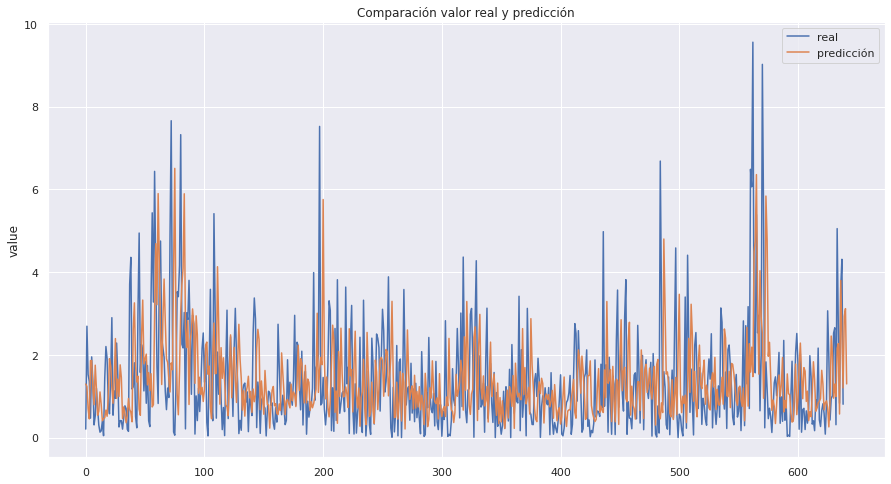

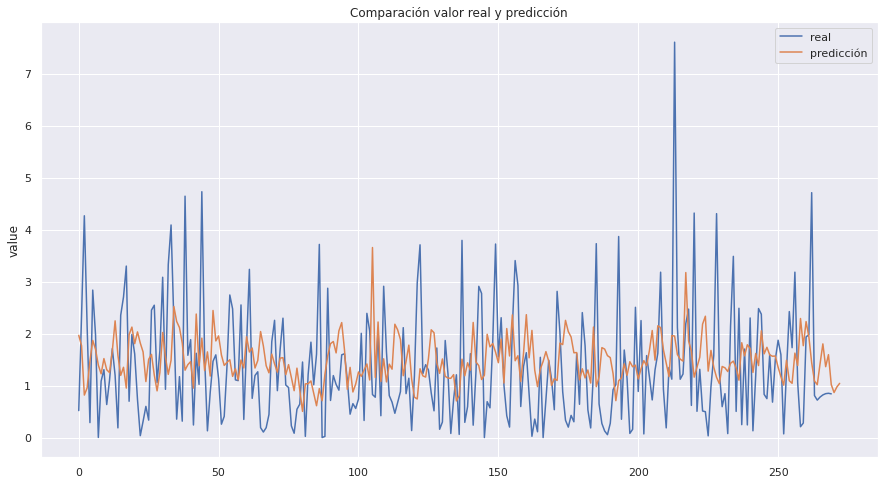

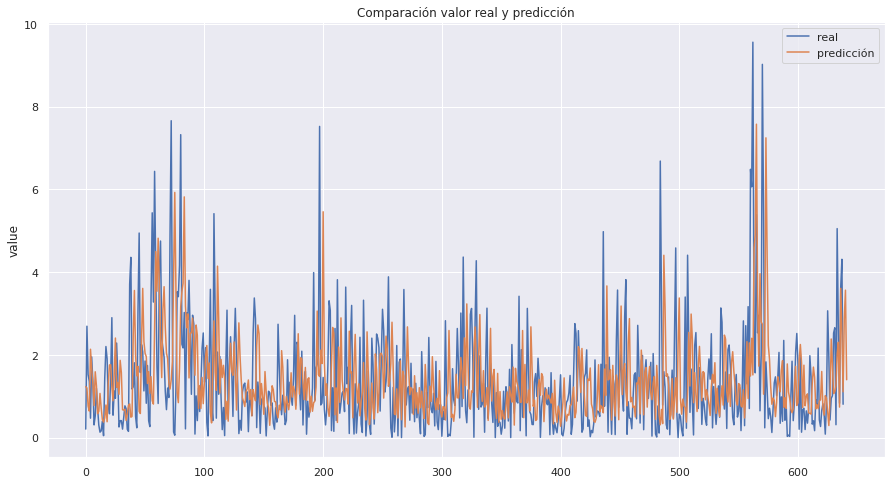

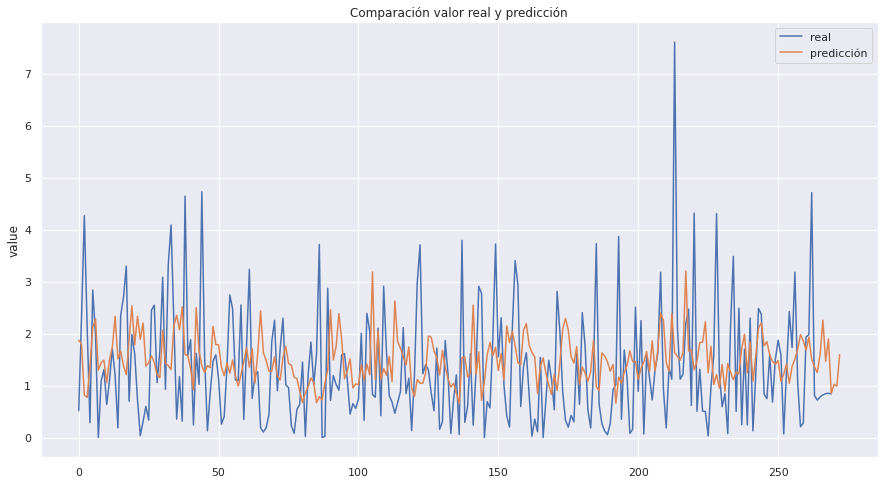

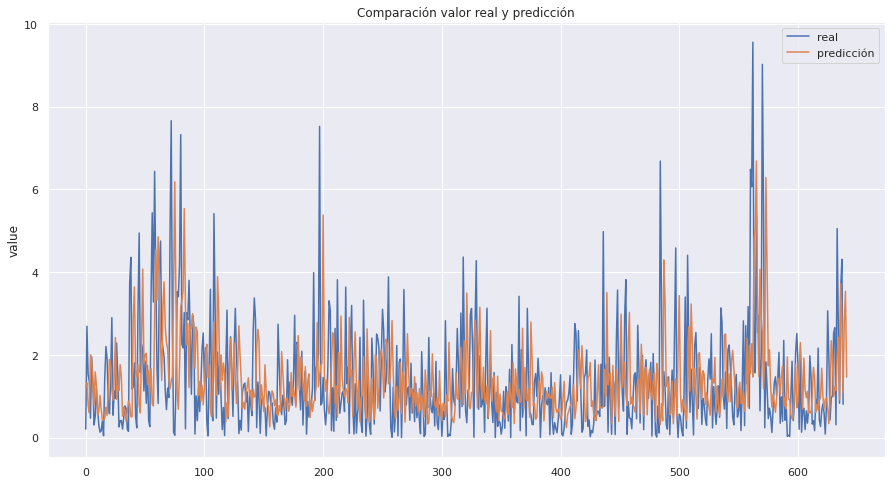

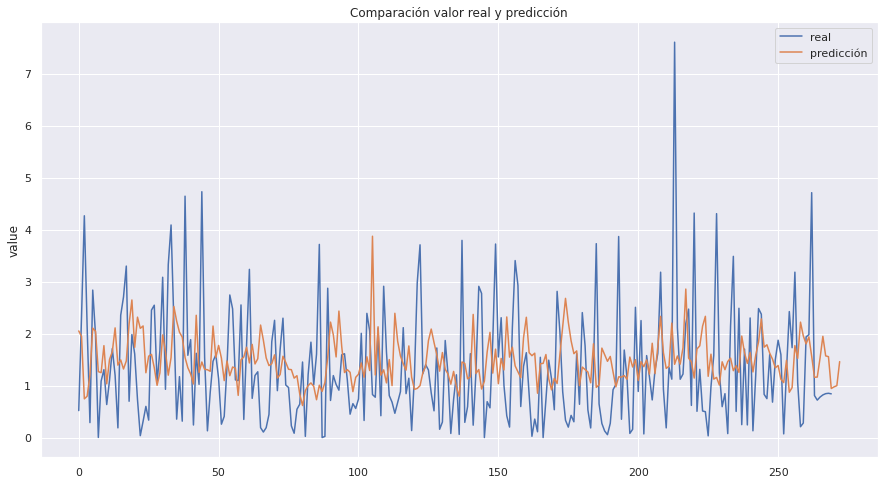

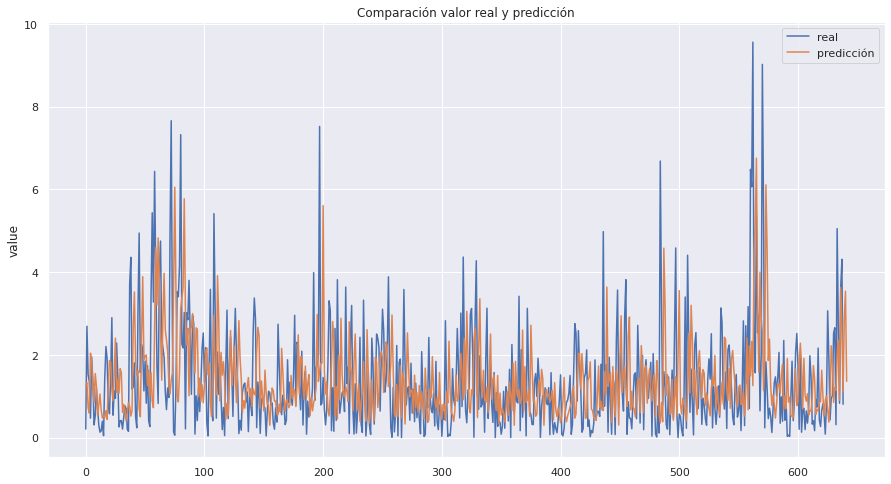

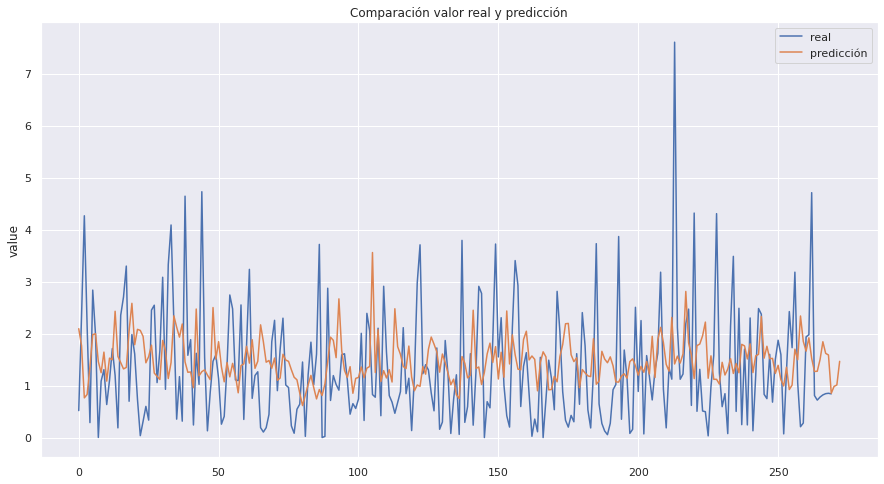

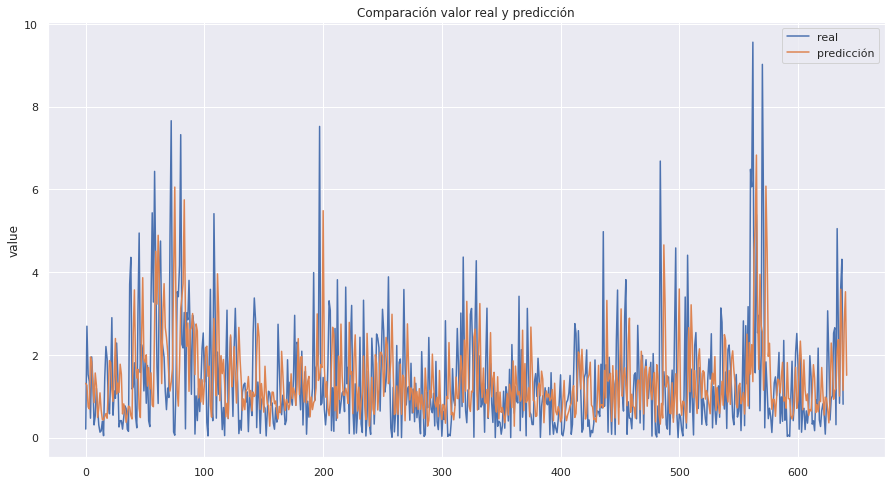

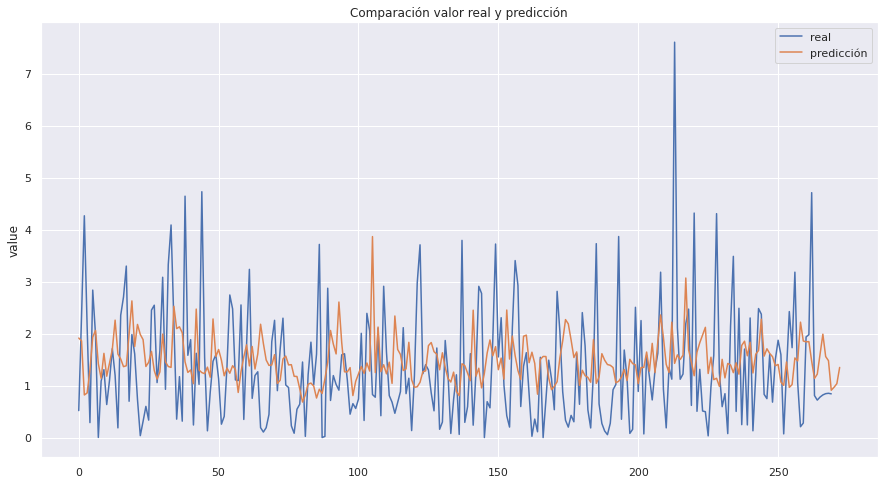

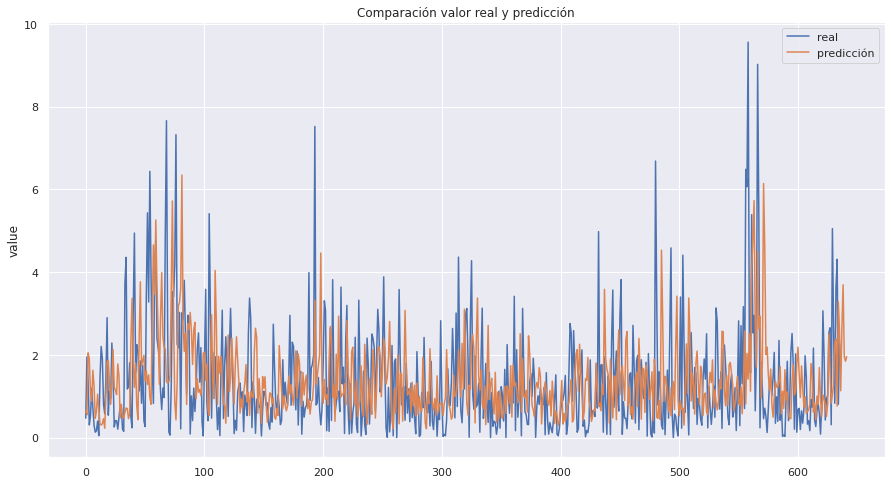

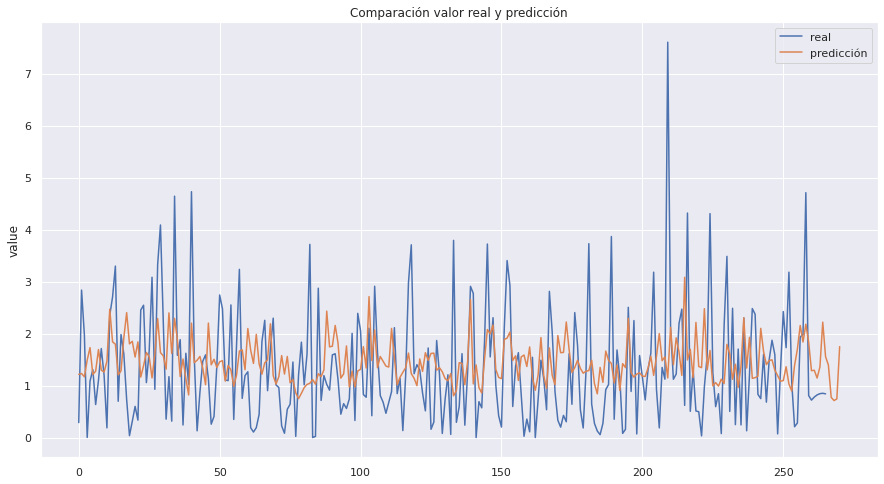

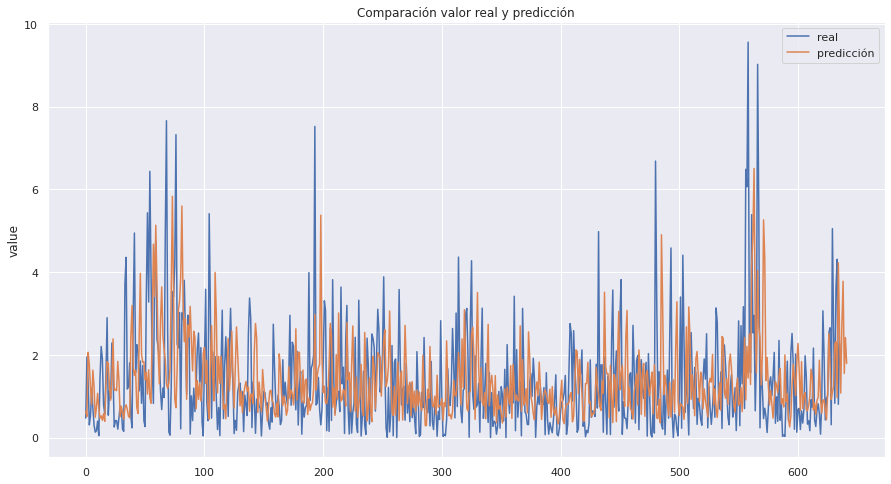

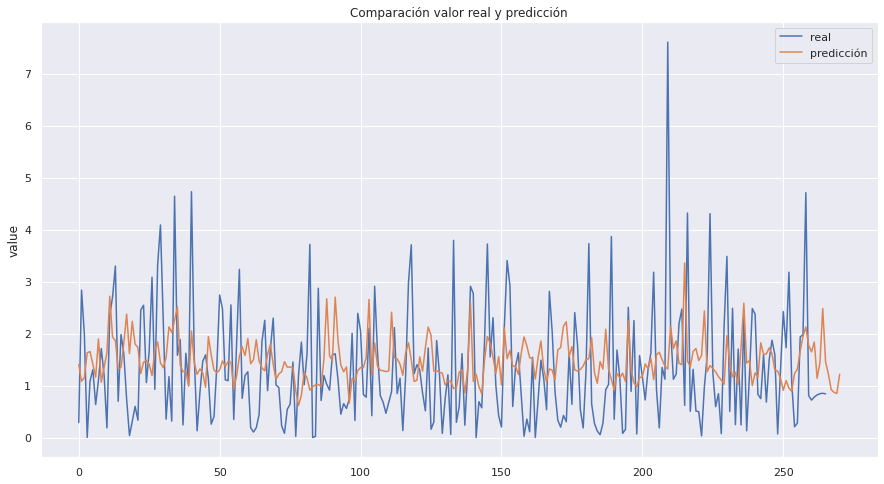

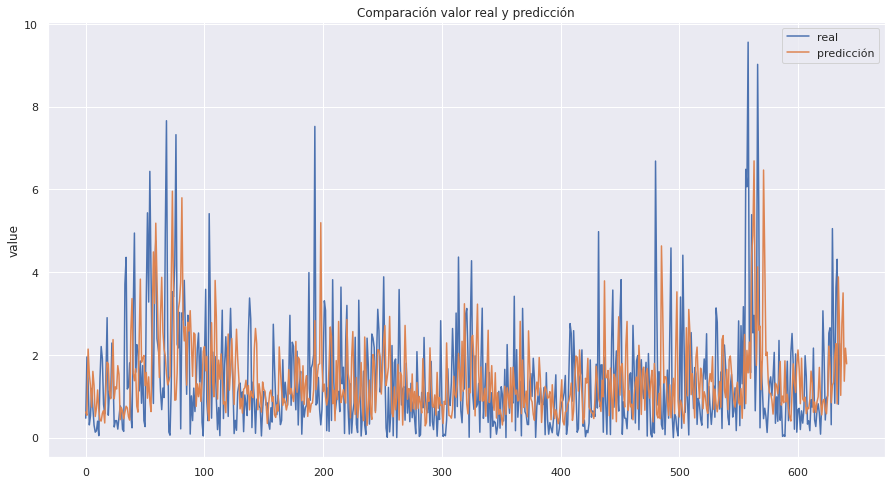

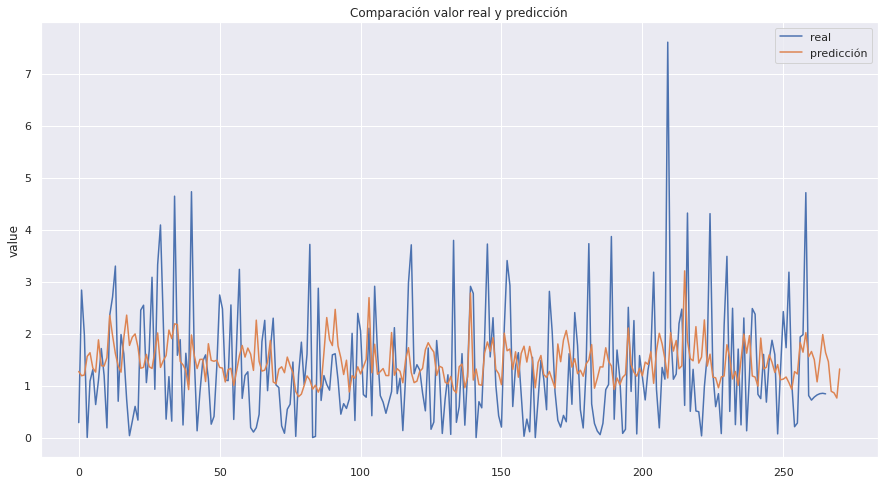

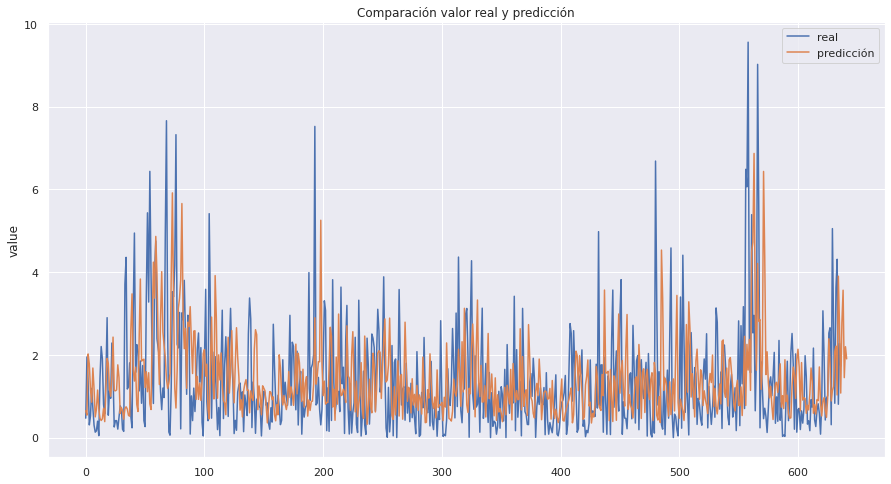

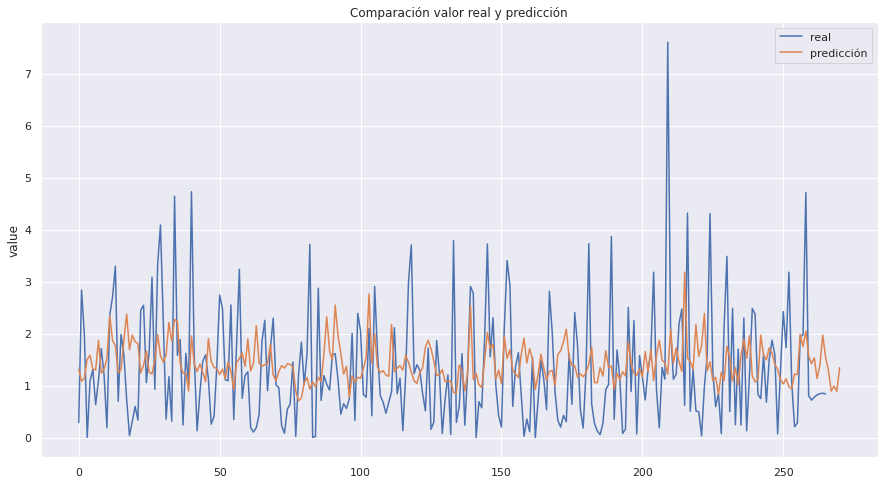

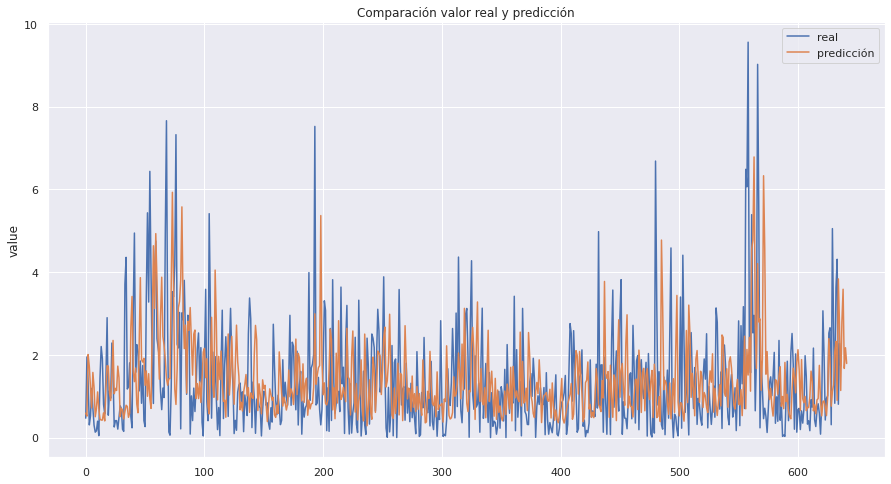

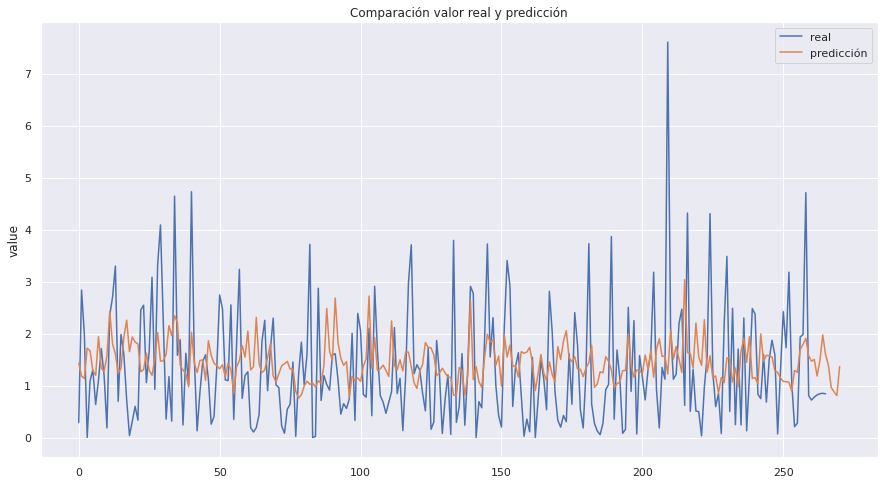

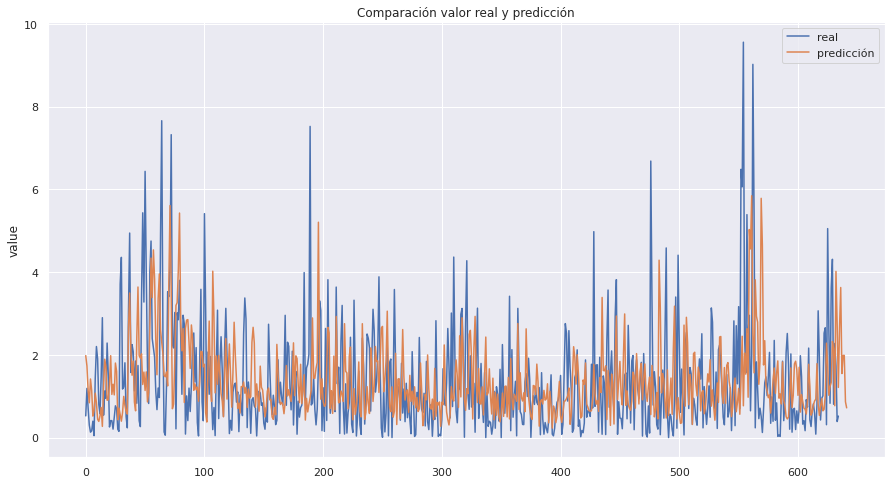

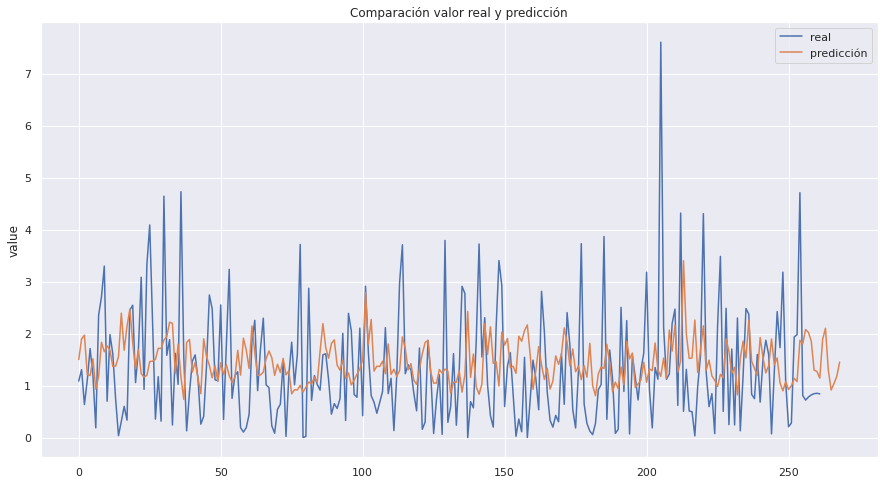

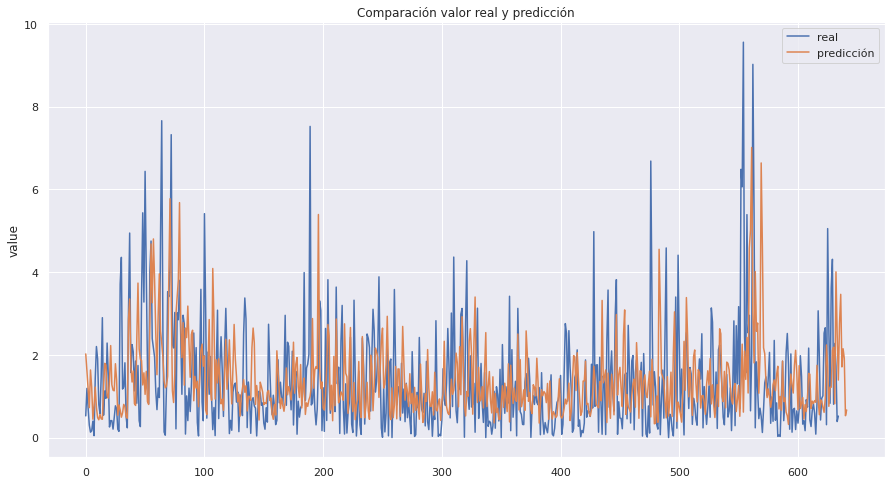

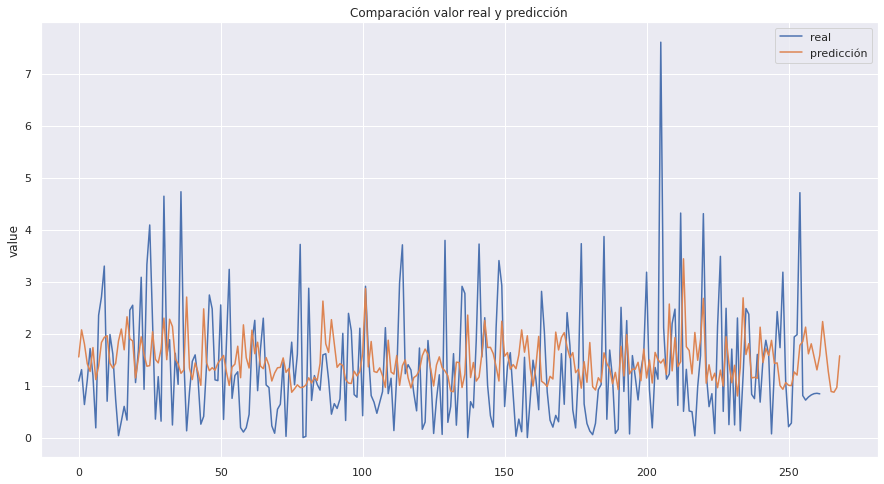

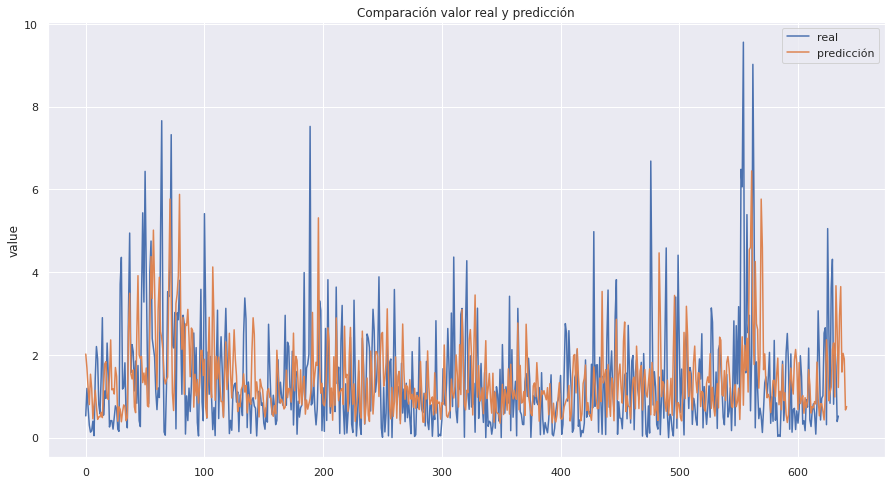

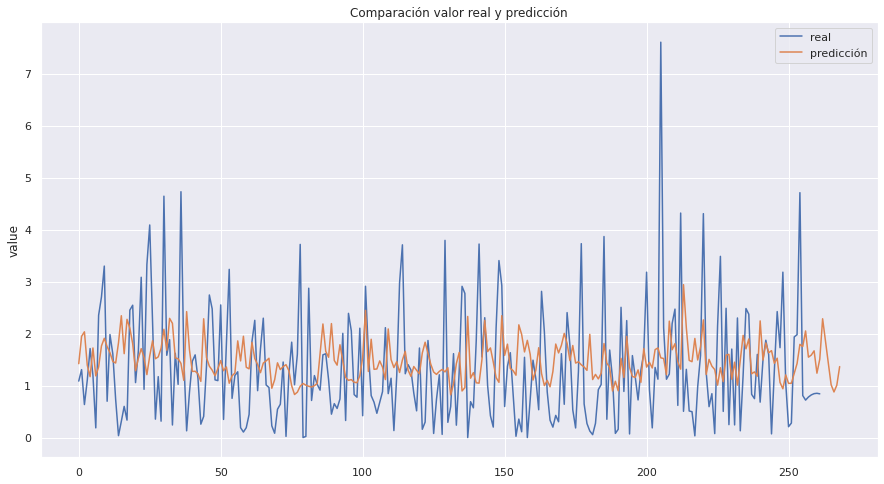

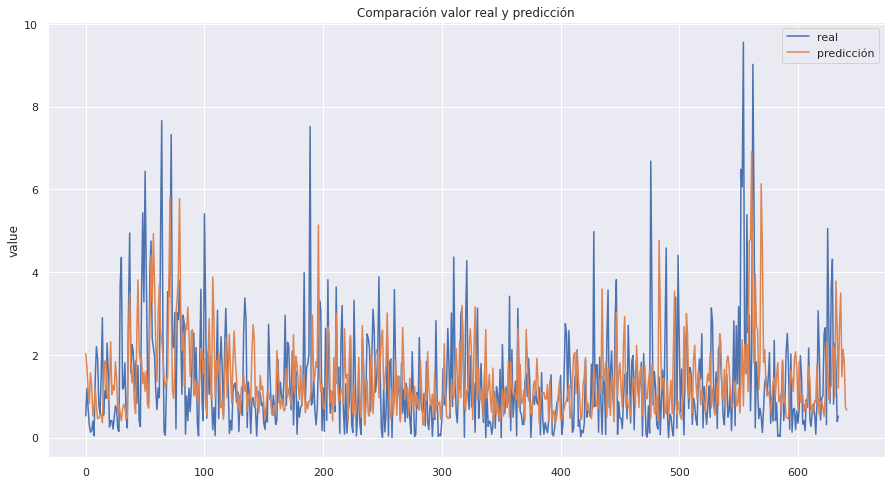

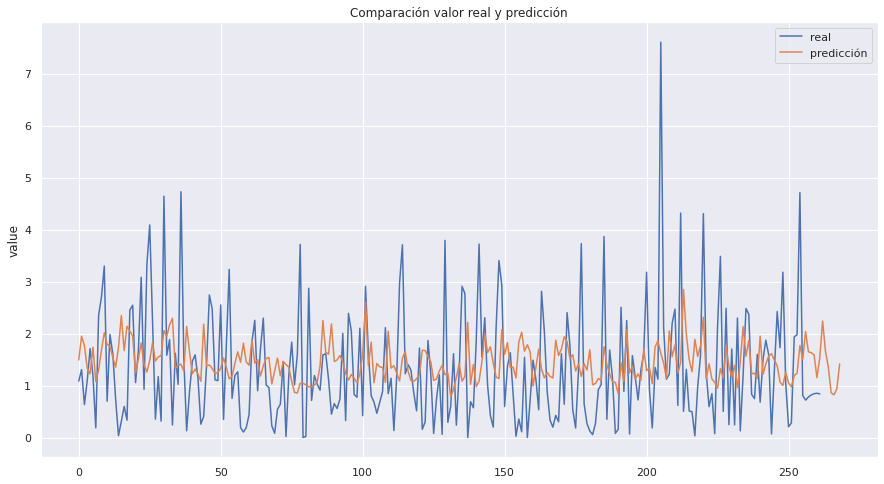

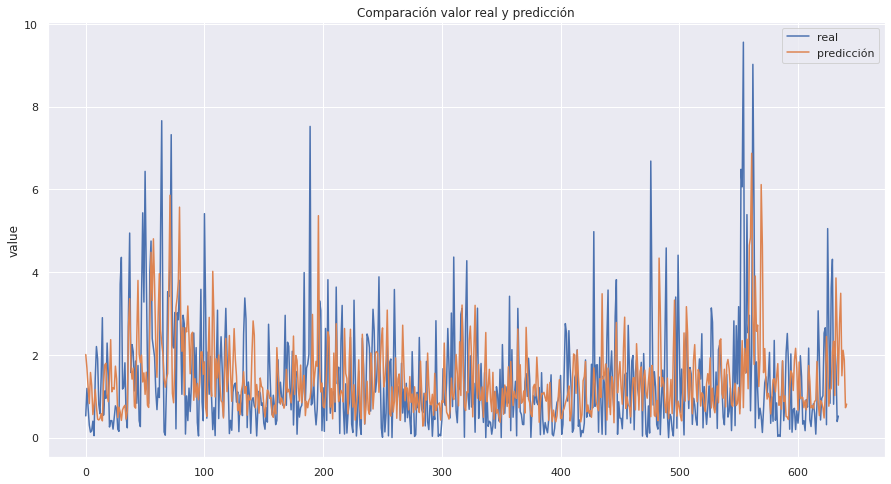

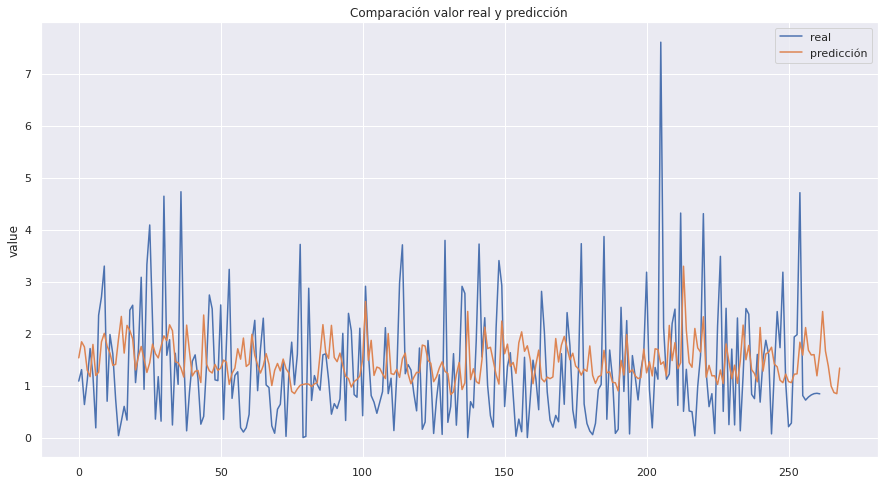

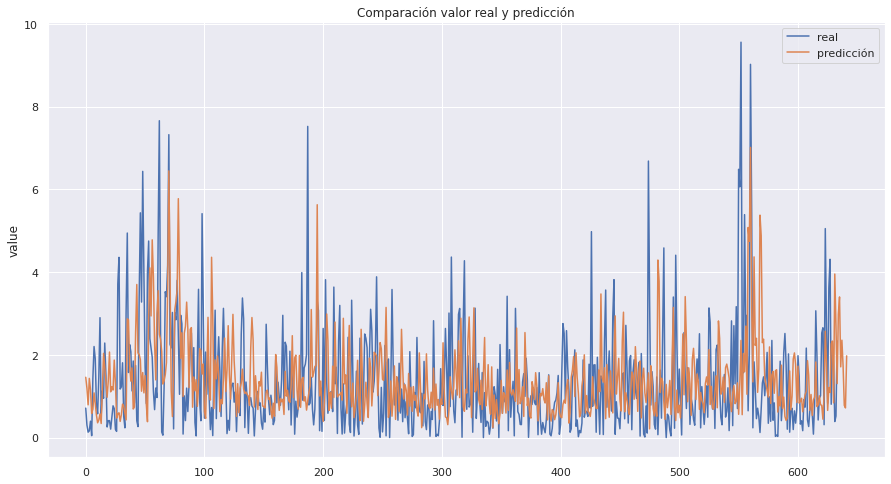

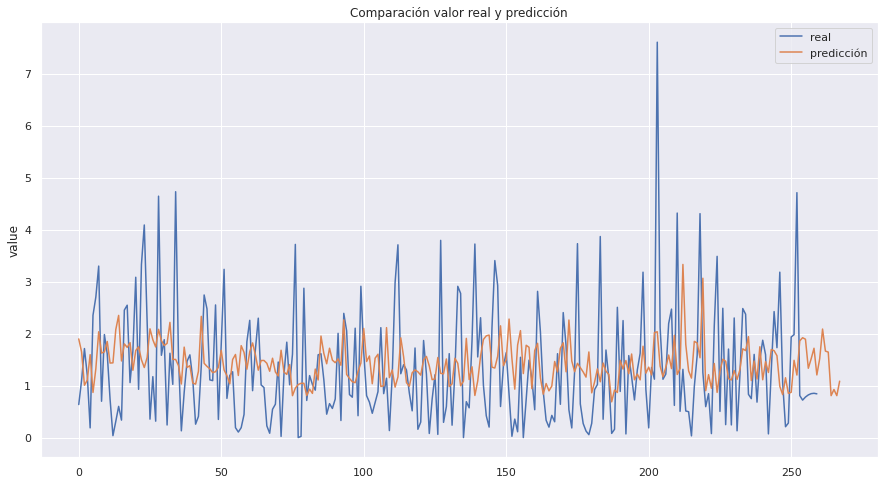

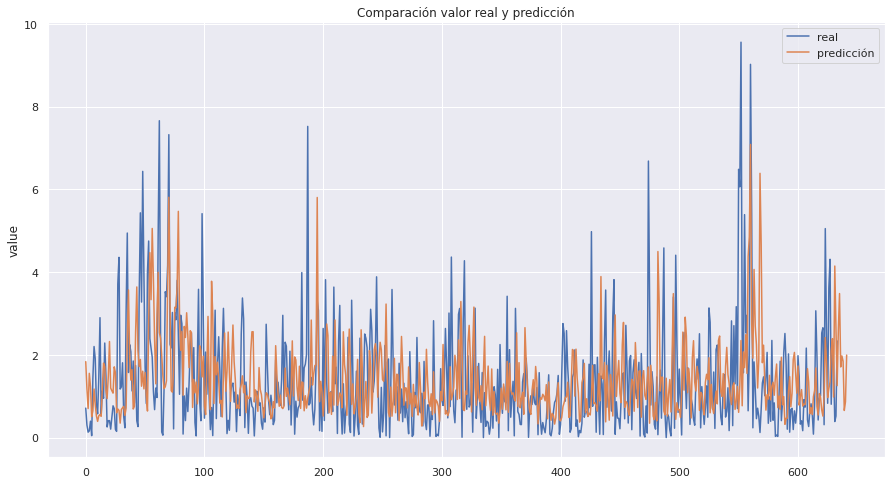

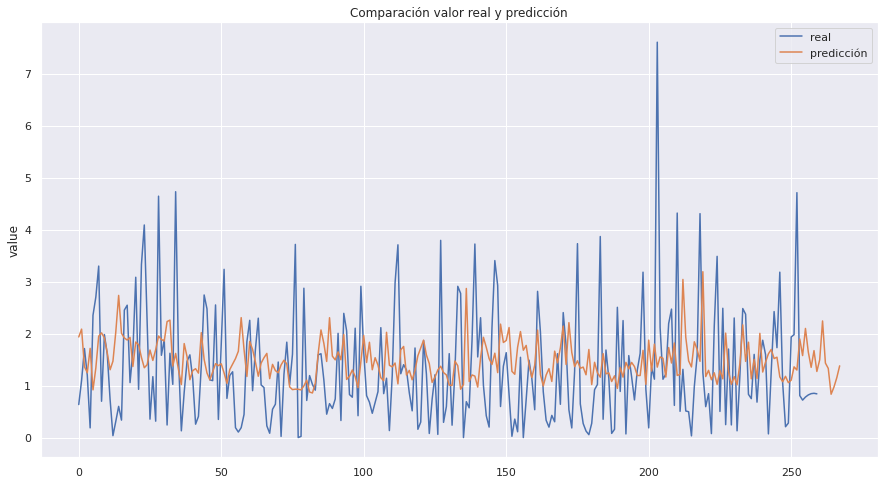

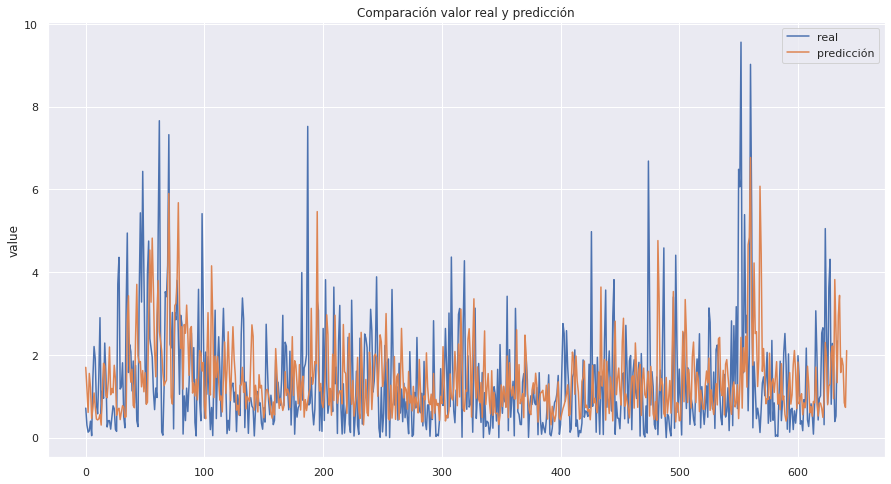

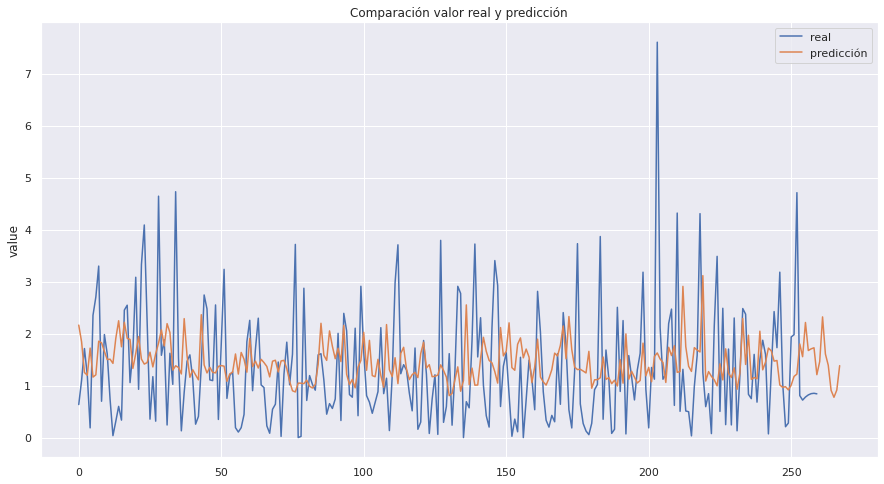

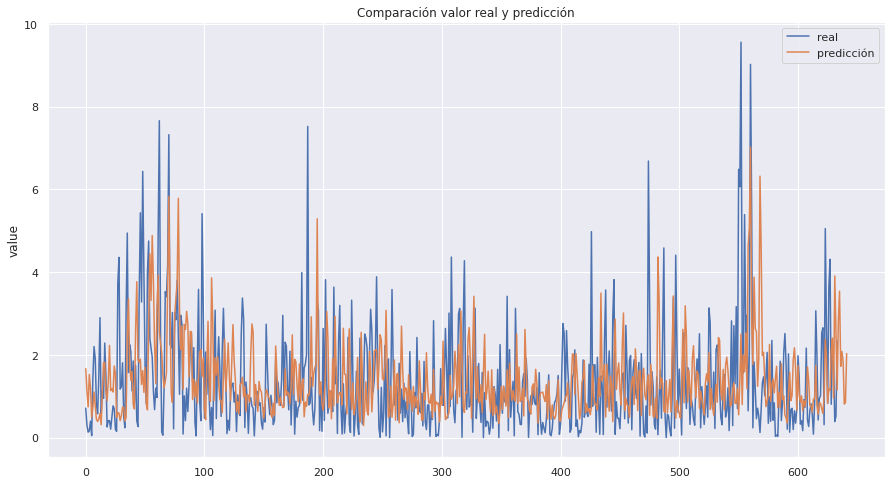

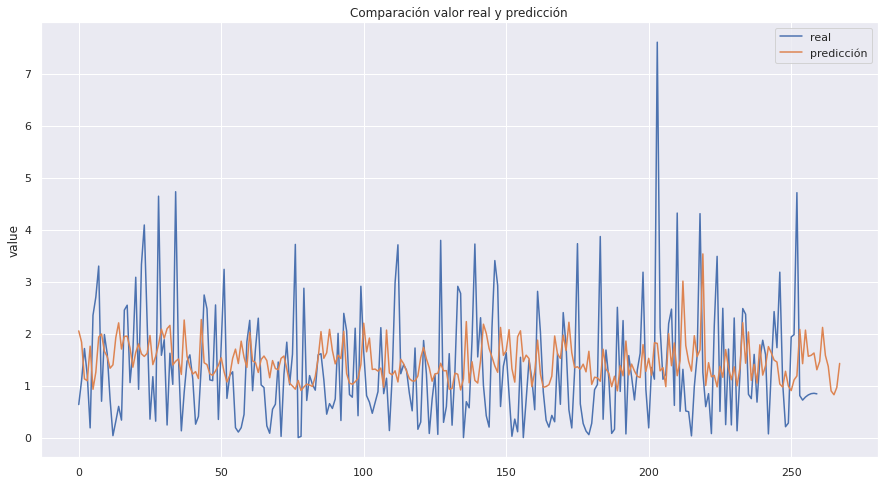

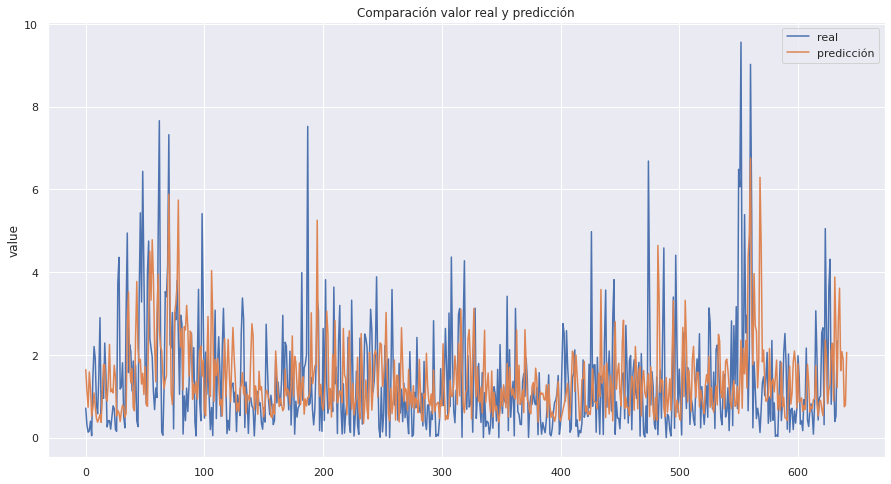

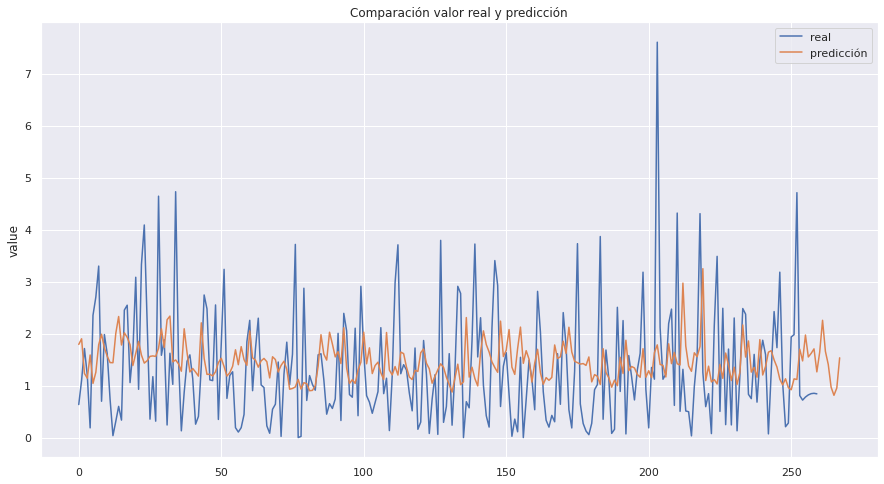

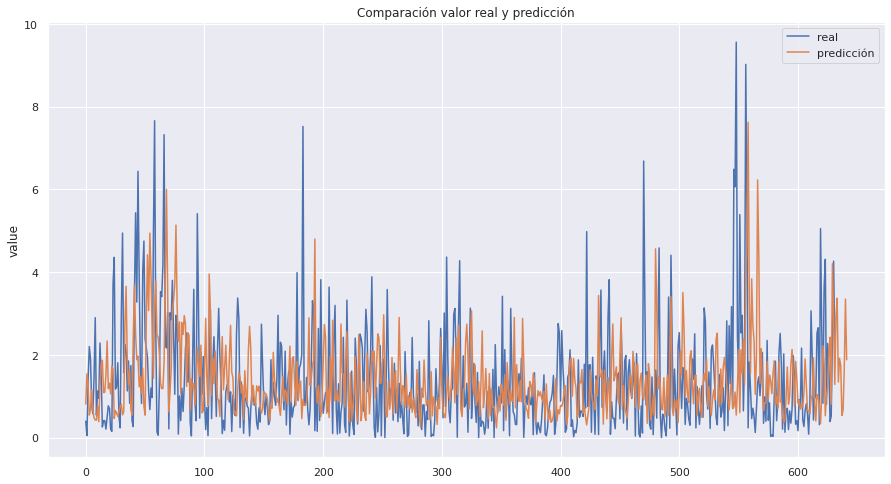

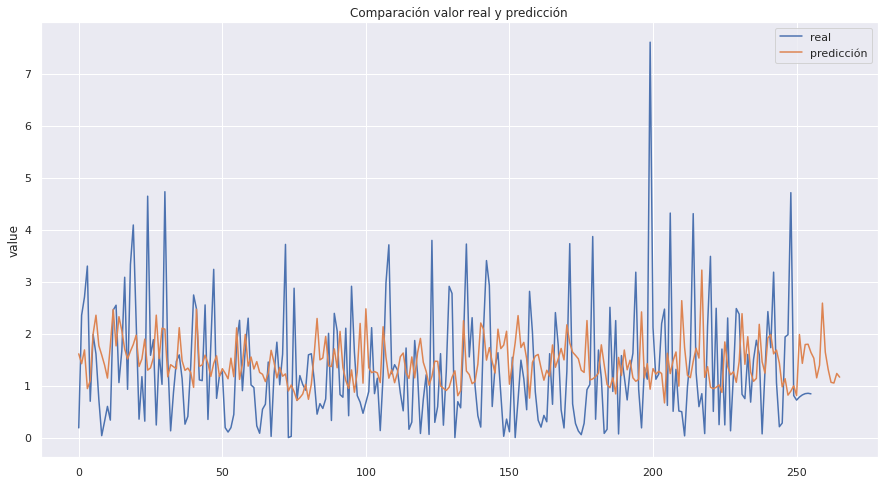

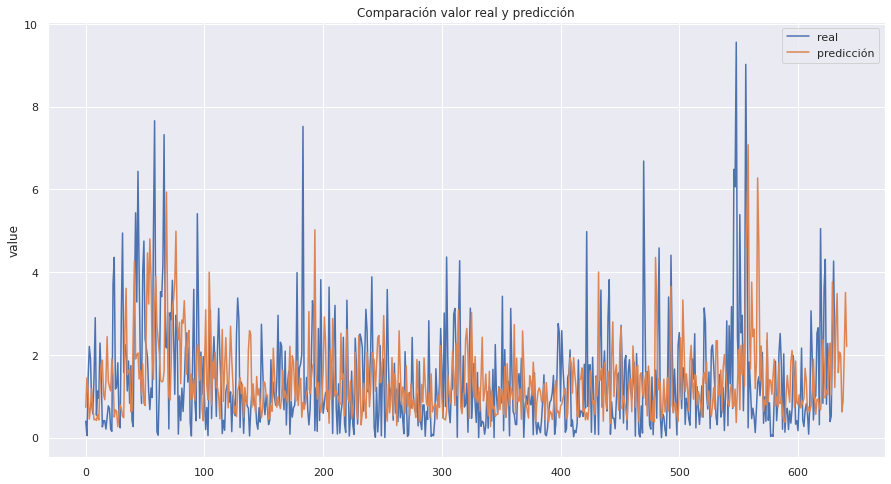

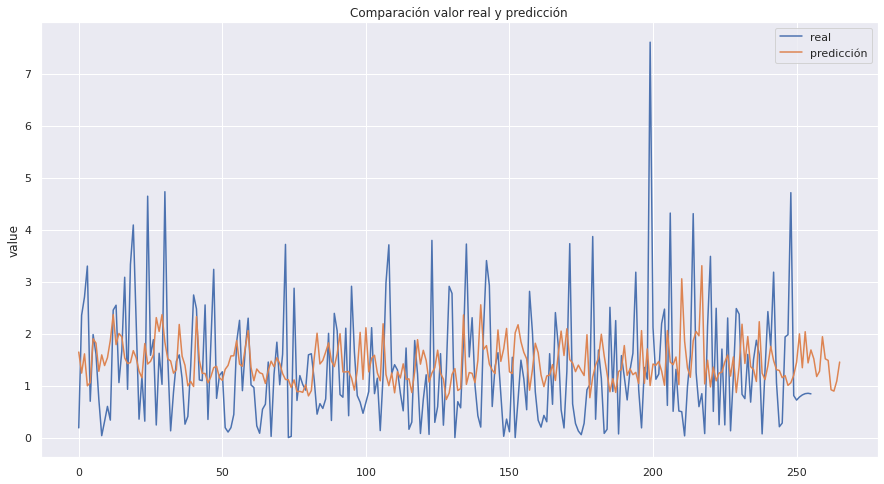

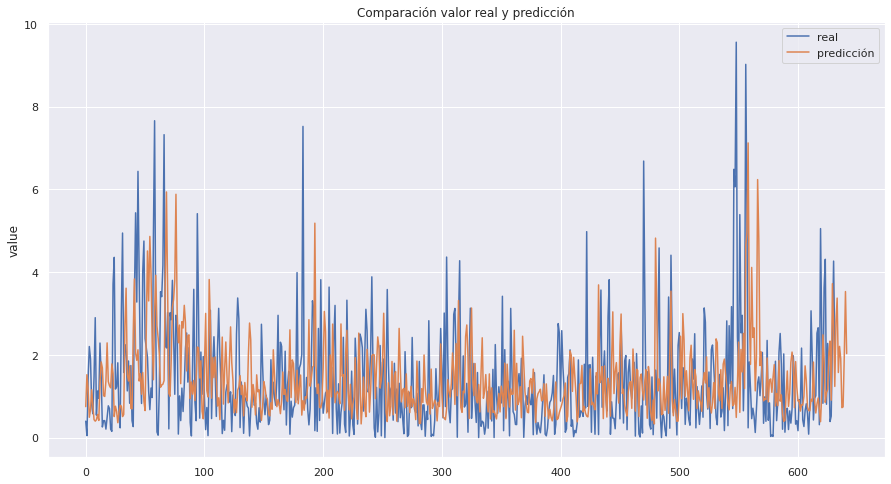

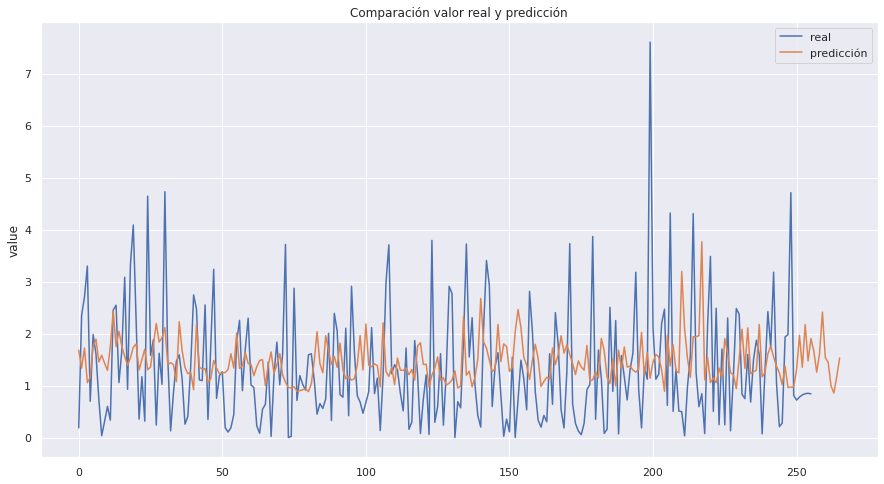

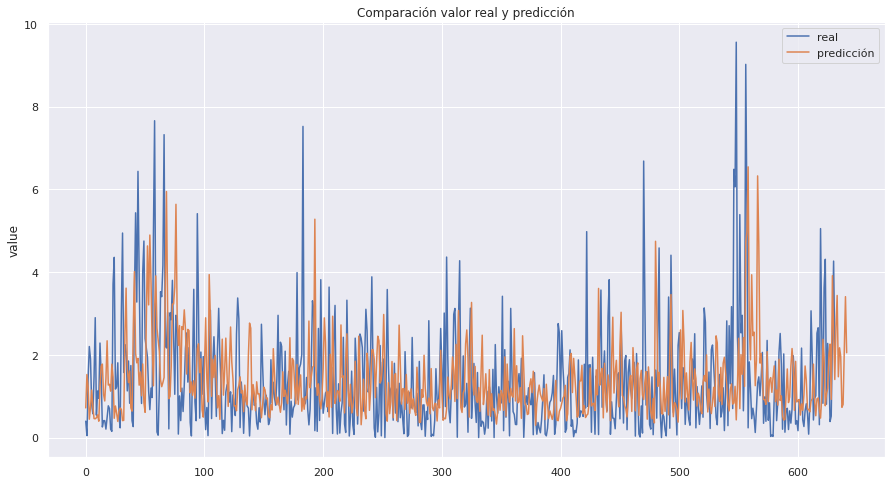

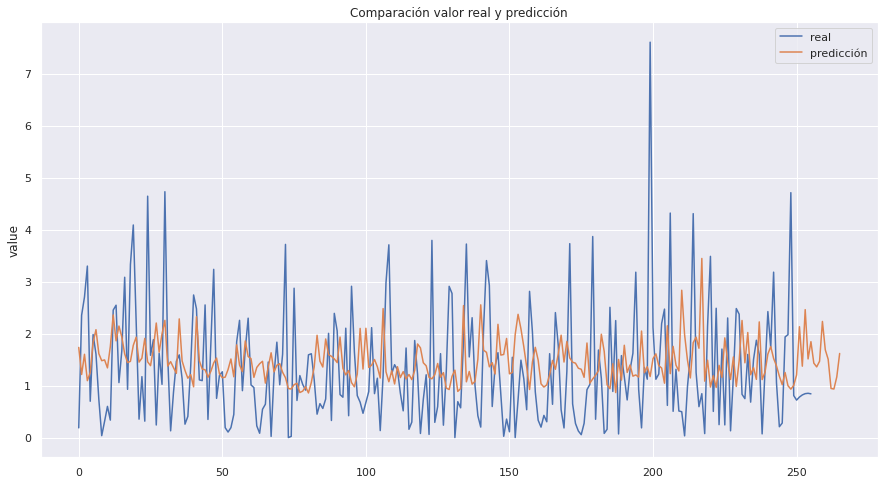

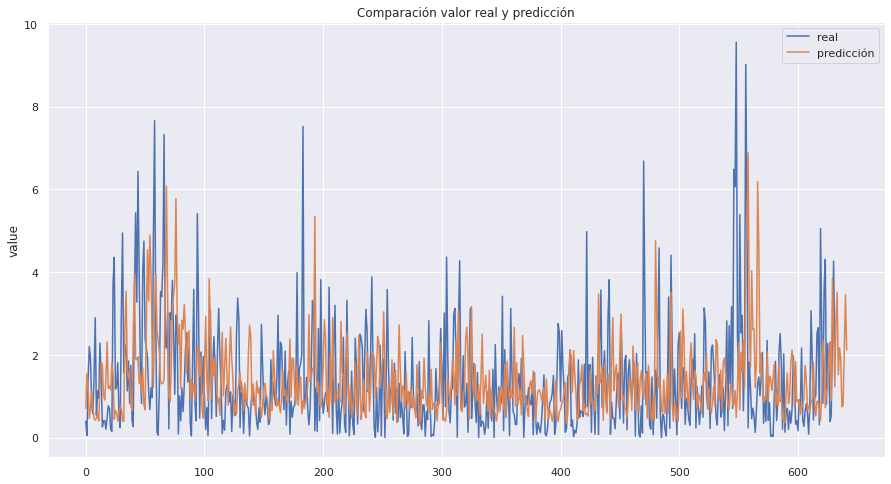

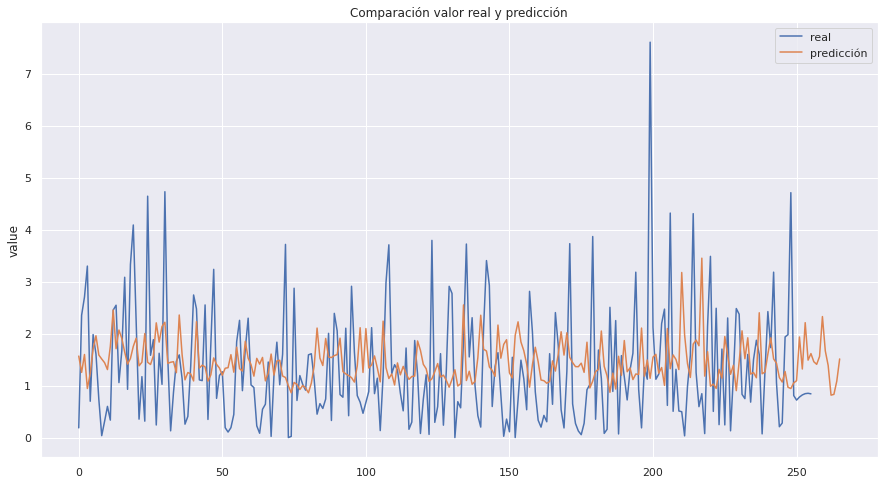

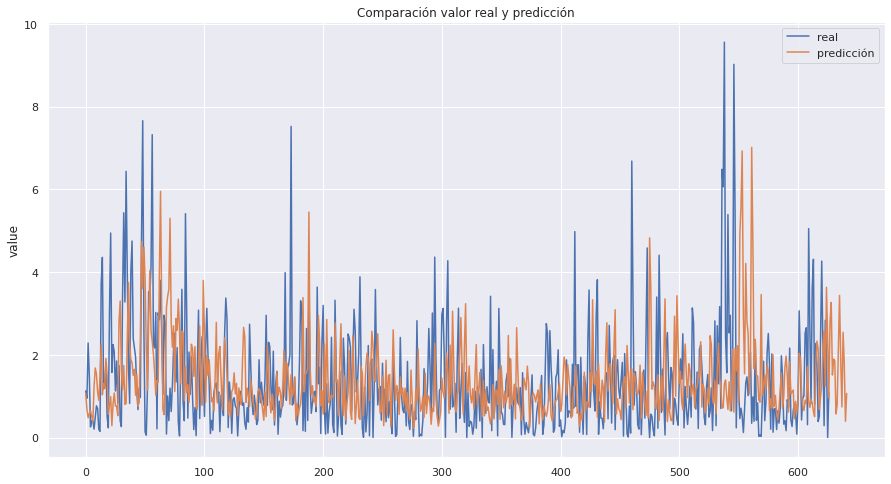

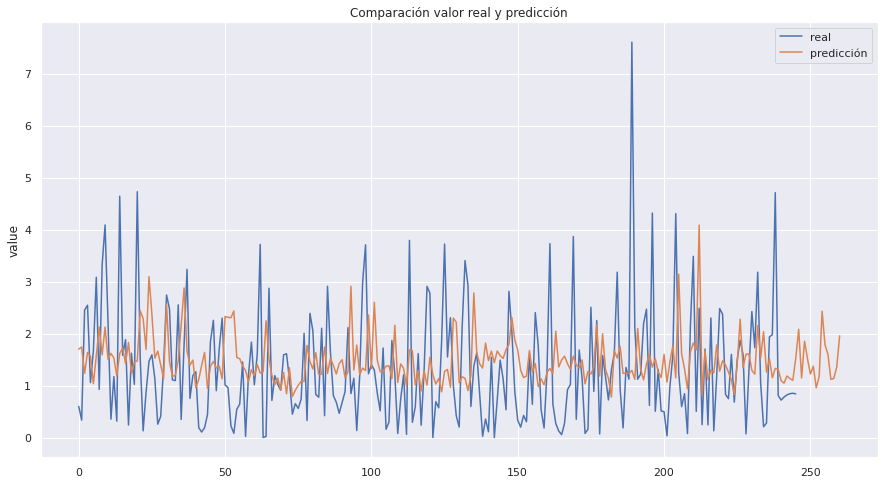

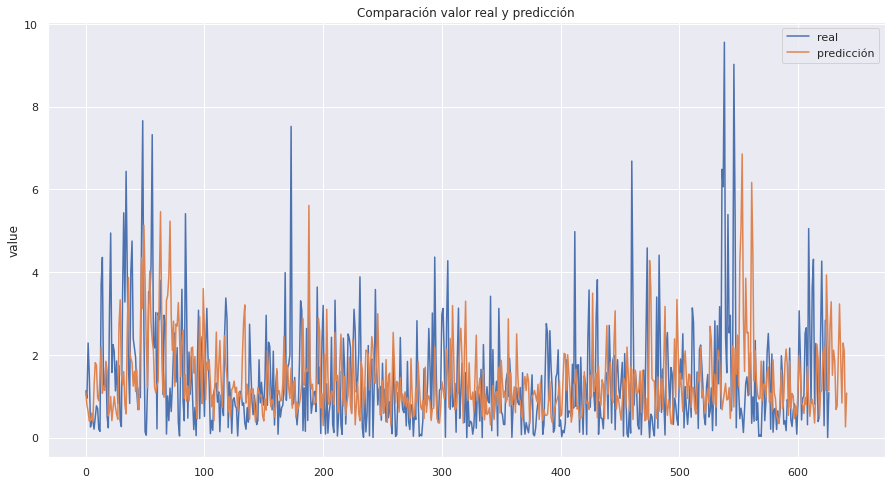

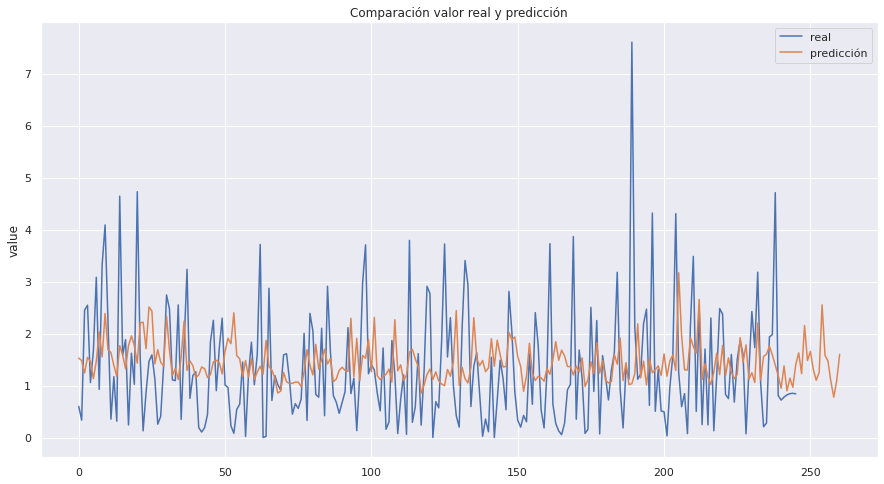

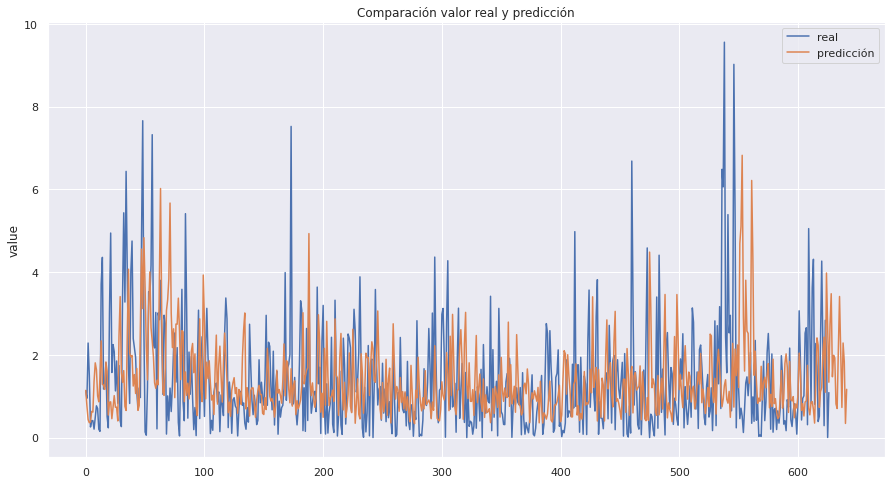

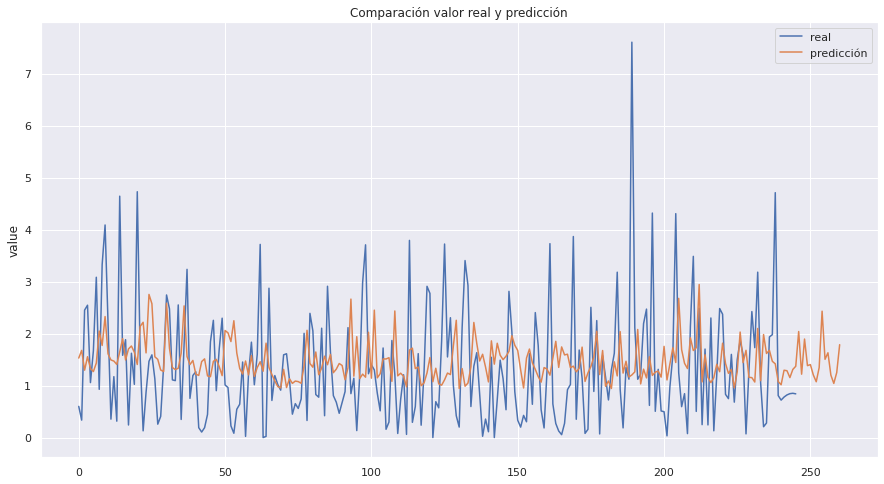

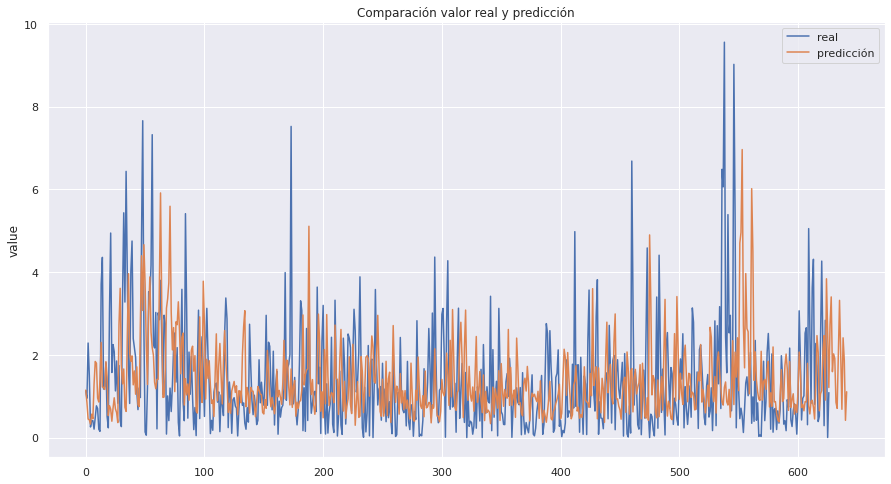

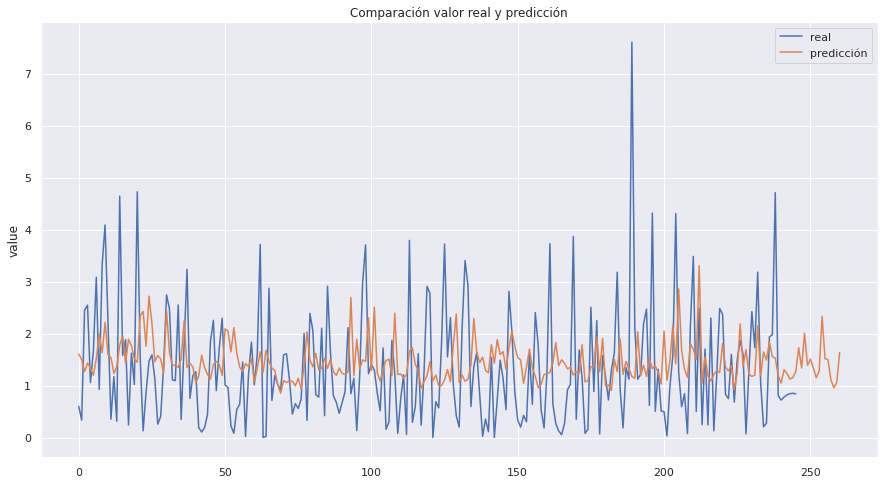

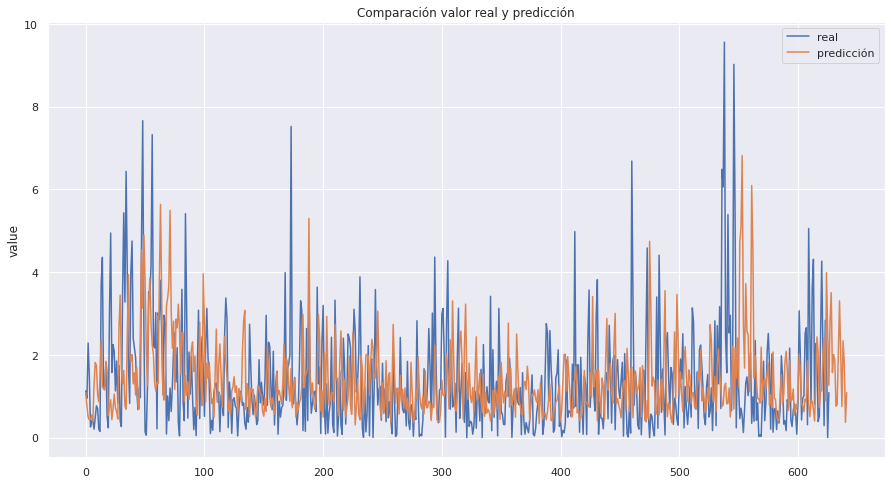

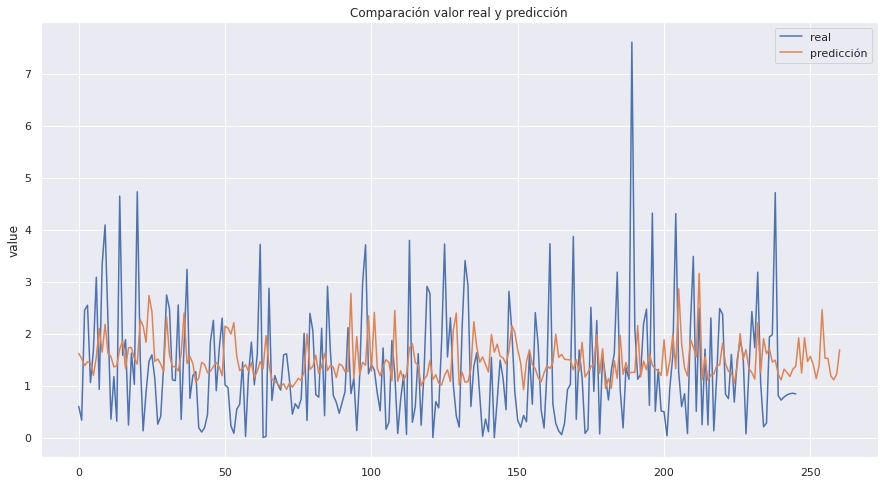

In [11]:
lags=[3,5,7,8,10,15]
n_estimators=[50,100,200,300,500]
results_models={i:{} for i in lags}
for lg in lags:
    for est in n_estimators:
        results_models[lg][est]=Model(df_data.copy(),df_label.copy(),lg,est)